In [1]:
import keras
import pandas as pd
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import RMSprop, SGD, Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
from keras.utils import plot_model
import matplotlib.pyplot as plt
import os
os.environ["PATH"] += os.pathsep + 'C://Graphviz2.38/bin/'
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
number_of_classes = 7
batch_size = 64
image_rows, image_columns = 48, 48
patience=30
epochs=50

In [3]:
training_dir = 'fer2013/train/'
validation_dir = 'fer2013/test/'

training_data_generator = ImageDataGenerator(rescale=1./255, rotation_range=30, shear_range=0.3,
                                             zoom_range=0.3, width_shift_range=0.4, height_shift_range=0.4, horizontal_flip=True, vertical_flip=True)

validation_data_generator = ImageDataGenerator(rescale=1./255)

model_train_generator = training_data_generator.flow_from_directory(training_dir, target_size=(
    image_rows, image_columns), color_mode='grayscale', class_mode='categorical', shuffle=True, batch_size=batch_size)

model_validation_generator = validation_data_generator.flow_from_directory(validation_dir, target_size=(
    image_rows, image_columns), color_mode='grayscale', class_mode='categorical', shuffle=True, batch_size=batch_size)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [4]:
def count_emotions(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = path + expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df

train_emotions_count = count_emotions(training_dir, 'Training Set')
test_emotions_count  = count_emotions(validation_dir, 'Validation Set')

print(train_emotions_count)
print(test_emotions_count)

              angry  disgust  fear  happy  neutral   sad  surprise
Training Set   3995      436  4097   7215     4965  4830      3171
                angry  disgust  fear  happy  neutral   sad  surprise
Validation Set    958      111  1024   1774     1233  1247       831


<AxesSubplot:>

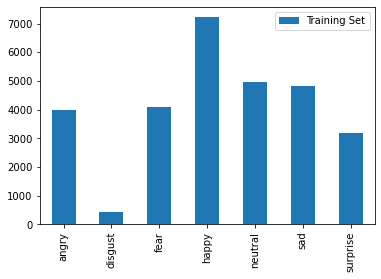

In [5]:
# Plotting test data 
train_emotions_count.transpose().plot(kind = 'bar')

<AxesSubplot:>

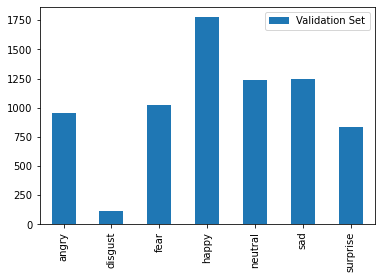

In [6]:
# Plotting validation data 
test_emotions_count.transpose().plot(kind = 'bar')

In [7]:
def plot_emotion_images(item_dir, top = 10):
    all_item_dirs = os.listdir(item_dir)
    item_files    = [os.path.join(item_dir, file) for file in all_item_dirs][:5]
  
    plt.figure(figsize = (10, 10))
  
    for idx, img_path in enumerate(item_files):
        plt.subplot(5, 5, idx + 1)
    
        img = plt.imread(img_path)
        plt.tight_layout()         
        plt.imshow(img, cmap = 'gray')

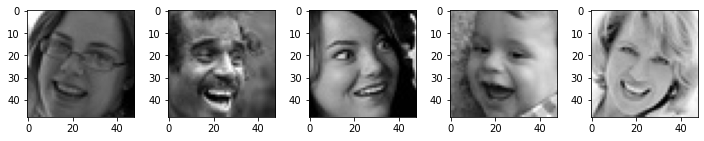

In [8]:
#plotting happy images
plot_emotion_images(training_dir + 'happy')

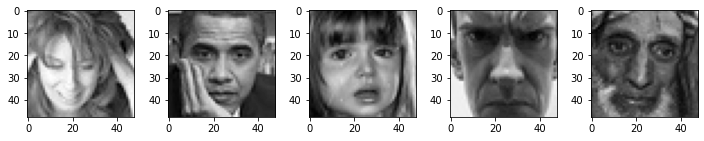

In [9]:
#plotting happy images
plot_emotion_images(training_dir + 'sad')

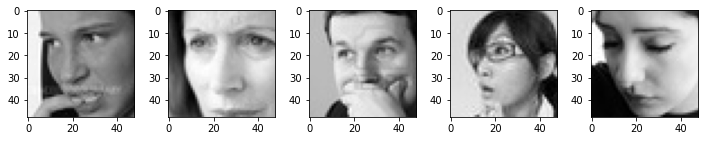

In [10]:
#plotting happy images
plot_emotion_images(training_dir + 'fear')

In [11]:
model = Sequential()

# Model training first block
model.add(Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal', input_shape=(image_rows, image_columns, 1)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal', input_shape=(image_rows, image_columns, 1)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Model training second block
model.add(Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

#Model training third block
model.add(Conv2D(256, (3, 3), padding='same', kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(256, (3, 3), padding='same', kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# model training block fourth flattening
model.add(Flatten())
model.add(Dense(64, kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

# model training block fifth activation function
model.add(Dense(number_of_classes, kernel_initializer='he_normal'))
model.add(Activation('softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 64)        640       
_________________________________________________________________
activation (Activation)      (None, 48, 48, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 64)        36928     
_________________________________________________________________
activation_1 (Activation)    (None, 48, 48, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0

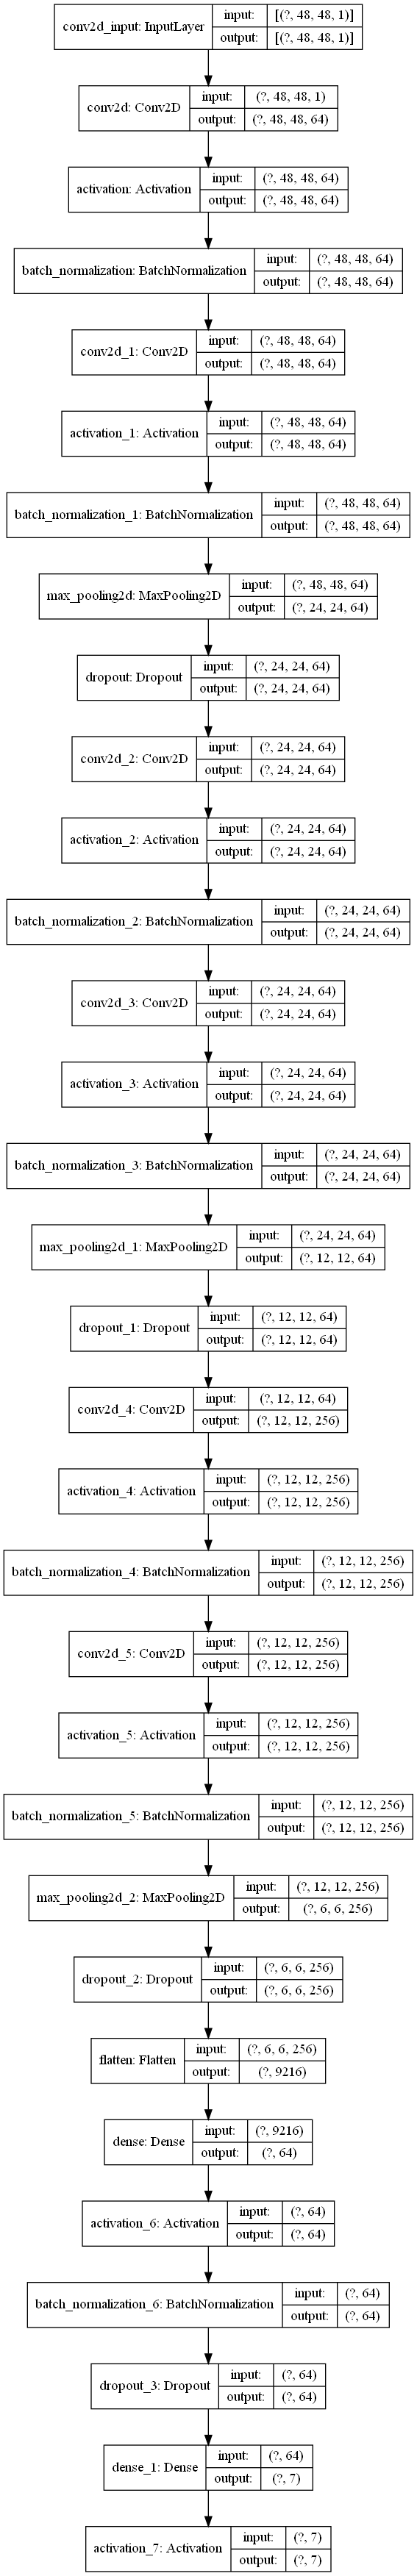

In [12]:
plot_model(model, to_file = 'model.png', show_shapes = True, show_layer_names = True)

In [5]:
checkpoint = ModelCheckpoint('model.epoch_{epoch:02d}-val_acc{val_accuracy:.2f}-train_acc{accuracy:.2f}-relu.hdf5', monitor='val_loss',mode='min',save_best_only=True, verbose=1)

earlyStopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=patience, verbose=1, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=patience, verbose=1,min_delta=0.0001)

callbacks = [earlyStopping, checkpoint, reduce_lr]

model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001),metrics=['accuracy'])

nb_train_samples = 28709
nb_validation_samples = 7178

history=model.fit(
                model_train_generator,
                steps_per_epoch=nb_train_samples//batch_size,
                epochs=epochs,
                callbacks=callbacks,
                validation_data=model_validation_generator,
                validation_steps=nb_validation_samples//batch_size)

Epoch 1/50
448/448 [==============================] - ETA: 0s - loss: 1.9449 - accuracy: 0.2145
Epoch 00001: val_loss improved from inf to 1.78642, saving model to model.epoch_01-val_acc0.26-train_acc0.21-relu.hdf5
448/448 [==============================] - 286s 639ms/step - loss: 1.9449 - accuracy: 0.2145 - val_loss: 1.7864 - val_accuracy: 0.2592
Epoch 2/50
448/448 [==============================] - ETA: 0s - loss: 1.8341 - accuracy: 0.2369
Epoch 00002: val_loss did not improve from 1.78642
448/448 [==============================] - 296s 660ms/step - loss: 1.8341 - accuracy: 0.2369 - val_loss: 1.8899 - val_accuracy: 0.2395
Epoch 3/50
448/448 [==============================] - ETA: 0s - loss: 1.8116 - accuracy: 0.2448
Epoch 00003: val_loss improved from 1.78642 to 1.75789, saving model to model.epoch_03-val_acc0.27-train_acc0.24-relu.hdf5
448/448 [==============================] - 293s 654ms/step - loss: 1.8116 - accuracy: 0.2448 - val_loss: 1.7579 - val_accuracy: 0.2722
Epoch 4/50
448

Epoch 26/50
448/448 [==============================] - ETA: 0s - loss: 1.2830 - accuracy: 0.5117
Epoch 00026: val_loss improved from 1.12684 to 1.10991, saving model to model.epoch_26-val_acc0.57-train_acc0.51-relu.hdf5
448/448 [==============================] - 289s 644ms/step - loss: 1.2830 - accuracy: 0.5117 - val_loss: 1.1099 - val_accuracy: 0.5737
Epoch 27/50
448/448 [==============================] - ETA: 0s - loss: 1.2766 - accuracy: 0.5101
Epoch 00027: val_loss did not improve from 1.10991
448/448 [==============================] - 295s 658ms/step - loss: 1.2766 - accuracy: 0.5101 - val_loss: 1.1135 - val_accuracy: 0.5696
Epoch 28/50
448/448 [==============================] - ETA: 0s - loss: 1.2700 - accuracy: 0.5161
Epoch 00028: val_loss improved from 1.10991 to 1.10470, saving model to model.epoch_28-val_acc0.58-train_acc0.52-relu.hdf5
448/448 [==============================] - 290s 648ms/step - loss: 1.2700 - accuracy: 0.5161 - val_loss: 1.1047 - val_accuracy: 0.5804
Epoch 2

In [10]:
model = load_model('model.epoch_45-val_acc0.60-train_acc0.54-relu.hdf5')

In [14]:
#evaluating model with train images

score_train = model.evaluate(model_train_generator)
print('Test Loss: {}'.format(score_train[0]))
print('Test Accuracy: {}'.format(score_train[1]))

449/449 [==============================] - 32s 71ms/step - loss: 1.1426 - accuracy: 0.5681
Test Loss: 1.1426312923431396
Test Accuracy: 0.5681493878364563


In [23]:
#evaluating model with validation images

score_validation = model.evaluate(model_validation_generator)
print('Validation Loss: {}'.format(score_validation[0]))
print('Validation Accuracy: {}'.format(score_validation[1]))

113/113 [==============================] - 13s 116ms/step - loss: 1.0498 - accuracy: 0.5999
Validation Loss: 1.0497697591781616
Validation Accuracy: 0.5998885631561279


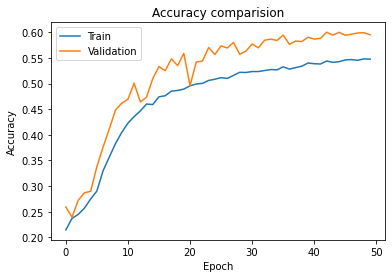

In [7]:
# graph visualization of train and validation accuracy

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy comparision')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

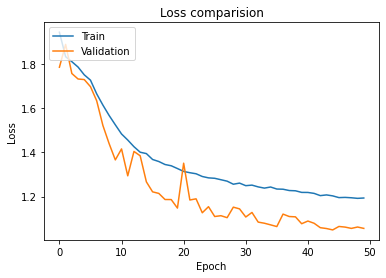

In [16]:
# graph visualization of train and validation loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss comparision')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [40]:
export = model.to_json() 
with open("model.json", "w") as json_file:     
    json_file.write(export) 
    model.save_weights("weight.h5")